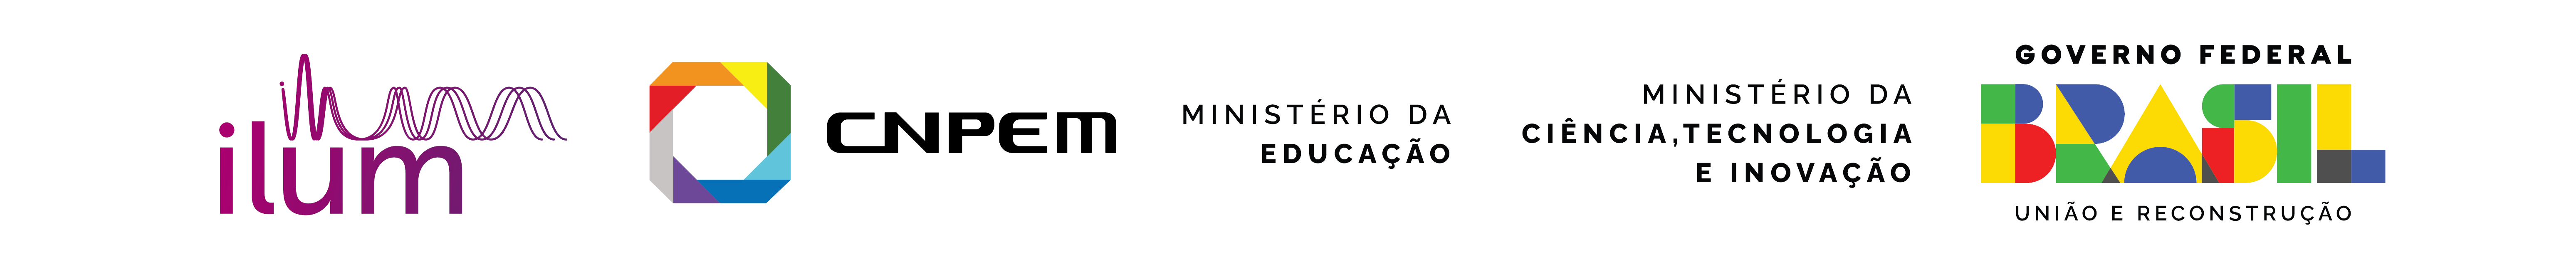

## <center> Fera formid√°vel 4.2 - <i> Early Stopping no PyTorch </i>
<b> Disciplina: </b> Redes Neurais e Algoritmos Gen√©ticos <br>
<b> Professor: </b> Daniel Cassar <br>
<b> Semestre: </b> 2025.1 <br>
<b> Alunas(os): </b> Let√≠cia Almeida Nunes e Vitor Gabriel Dreveck <br>
<b> RM: </b> 24013 e 24046<br>

---

### Objetivo

Implementar uma estrat√©gia de parada antecipada no treino da rede neural em PyTorch feita em aula.

### Introdu√ß√£o

Em modelos de redes neurais √© comum que ap√≥s muitas **√©pocas** de treino, depois de atingir um m√≠nimo, o modelo comece a se **sobreajustar** aos dados, fazendo com que a perda torne a aumentar. Para evitar o overfitting, √© poss√≠vel utilizar a estrat√©gia de **`early stopping`** ("parada antecipada" em portugu√™s) que consiste em colocar **crit√©rios de parada** no treino da rede.

<center>
    <figure>
        <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*2BvEinjHM4SXt2ge0MOi4w.png" alt="Gr√°fico ilustrando o early stopping">
        <figcaption> Fonte: <a href="https://medium.com/@rahuljain13101999/why-early-stopping-works-as-regularization-b9f0a6c2772">https://medium.com/@rahuljain13101999/why-early-stopping-works-as-regularization-b9f0a6c2772</a> </figcaption>
    </figure>
</center>    

Para mostrarmos como isso pode ser feito, adaptaremos a rede neural feita em PyTorch nas aulas e utilizaremos o data set de pinguins da biblioteca `seaborn`.

---

### Importa√ß√µes

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

---

### Data set üêß 

Abaixo, importamos os dados e selecionamos apenas a esp√©cie **Adelie** para prevermos a massa dos pinguins.

In [2]:
df = sns.load_dataset("penguins")

features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]
target = ["body_mass_g"]

# Selecionando a esp√©cide de interesse
adelies = df["species"] == "Adelie"
df = df.loc[adelies]

df = df.reindex(features + target, axis=1)
df = df.dropna()

X = df[features].values
y = df[target].values.reshape(-1, 1)

df

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0              39.1           18.7              181.0       3750.0
1              39.5           17.4              186.0       3800.0
2              40.3           18.0              195.0       3250.0
4              36.7           19.3              193.0       3450.0
5              39.3           20.6              190.0       3650.0
..              ...            ...                ...          ...
147            36.6           18.4              184.0       3475.0
148            36.0           17.8              195.0       3450.0
149            37.8           18.1              193.0       3750.0
150            36.0           17.1              187.0       3700.0
151            41.5           18.5              201.0       4000.0

[151 rows x 4 columns]

### Separa√ß√£o dos dados em treino, teste e valida√ß√£o

In [3]:
SEMENTE = 42
 
train_ratio = 0.25
validation_ratio = 0.25
test_ratio = 0.5
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEMENTE)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEMENTE)

Como estamos usando a biblioteca `PyTorch`, √© preciso transformar os dados em tensores.

In [4]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

---
Nas c√©lulas seguintes, copiamos o c√≥digo desenvolvido em aula e modificamos apenas o n√∫mero de neur√¥nios nas camadas ocultas.

### Classe `MLP`

In [5]:
class MLP(nn.Module):
    def __init__(self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets):
        super().__init__()
        
        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_c1),
            nn.Sigmoid(), # se n√£o for adicionada, ser√° como se a fun√ß√£o de ativa√ß√£o fosse uma identidade
            nn.Linear(neuronios_c1, neuronios_c2),
            nn.Sigmoid(),
            nn.Linear(neuronios_c2, num_targets), # geralmente, na regress√£o, n√£o √© adicionada uma fun√ß√£o de ativa√ß√£o
        )
        
    def forward(self, x): # equivalente ao __call__()
        x = self.camadas(x)
        return x

### Arquitetura da rede

In [6]:
num_dados_de_entrada = len(features)
num_dados_de_saida = len(target)  
NEURONIOS_C1 = 7
NEURONIOS_C2 = 7

minha_mlp = MLP(
    num_dados_de_entrada, NEURONIOS_C1, NEURONIOS_C2, num_dados_de_saida
)

### Otimizador e fun√ß√£o de perda

In [7]:
TAXA_DE_APRENDIZADO = 0.001

otimizador = optim.SGD(minha_mlp.parameters(), lr=TAXA_DE_APRENDIZADO)
fn_perda = nn.MSELoss()

### Treino e valida√ß√£o

Para implementar a parada antecipada, n√£o √© preciso modificar o treino da rede, mas apenas adicionar uma etapa de **valida√ß√£o**, na qual testaremos a rede ap√≥s cada √©poca com um conjunto de dados separados para esse fim (n√£o s√£o os dados de teste!). Com isso, podemos verificar como o modelo est√° realizando previs√µes para dados nunca vistos e, com base no comportamendo da **curva de aprendizado**, analisarmos se a **perda** est√° est√°vel o suficiente para interrompermos o treino.

Para isso precisamos estabelecer alguns par√¢metros essenciais para o crit√©rio de parada:

**`PATIENCE`** (paci√™ncia): N√∫mero de √©pocas que se deve esperar para inferir que o algoritmo estabilizou em um valor. Aqui, usamos 1% do total de √©pocas.

**`DELTA`** (delta): Varia√ß√£o m√°xima para que a diferen√ßa entre duas perdas seja considerada nula. Aqui, usamos 5% da varia√ß√£o absoluta do target (`escala`).

<div class="alert alert-info">
  <b>Crit√©rio de parada:</b> <i>Se a varia√ß√£o da perda entre duas √©pocas for menor ou igual ao delta por um n√∫mero de √©pocas igual √† paci√™ncia, o treino √© interrompido.</i>
</div>

Outro par√¢metro que poderia ser adicionado mas optamos por deixar de fora devido √† dificuldade de determin√°-lo √© o `threshold`. Este delimita um valor m√≠nimo ou m√°ximo que a perda pode atingir.

Todo esse processo tamb√©m pode ser feito com a fun√ß√£o `EarlyStopping` do m√≥dulo `ignite` do PyTorch, por√©m, por fins did√°ticos, n√£o o utilizamos nesse notebook.

Ademais, decidimos primeiramente continuar o treino mesmo ap√≥s atingirmos os crit√©rios de parada apenas para que fosse poss√≠vel mostrar no gr√°fico onde o early stopping foi chamado e apenas em seguida executaremos o c√≥digo novamente com a parada antecipada funcionando. Para isso adicionamos algumas linhas extras, por√©m o c√≥digo enxuto pode ser encontrado logo mais abaixo. <br><br>

<span style="color:red">
<b>Todas as altera√ß√µes para inserir a parada antecipada foram realizadas apenas na c√©lula abaixo!</b>
</span>

In [8]:
NUM_EPOCAS = 1000
PATIENCE = int(0.01*NUM_EPOCAS)

escala = abs(torch.max(y_val)-torch.min(y_val))
DELTA = 0.05*escala

perda_treino = [] # essa linha pode ser removida se o treino for interrompido normalmente
perda_validacao = []
finalizado = False # essa linha pode ser removida se o treino for interrompido normalmente
contador = 0 
                 
for epoca in range(NUM_EPOCAS):
    # TREINO -----------------------------------------------------
    minha_mlp.train()
    
        # forward pass
    y_pred = minha_mlp(X_train)

        # zero grad
    otimizador.zero_grad()

        # loss
    loss = fn_perda(y_train, y_pred)
    perda_treino += [loss.data] # Essa linha foi adicionada apenas para gerar a curva de aprendizado

        # backpropagation
    loss.backward()

        # atualiza par√¢metros
    otimizador.step()    
    
    
    # VALIDA√á√ÉO --------------------------------------------------
    minha_mlp.eval()
    
    with torch.no_grad():
        # forward pass
        y_pred = minha_mlp(X_val)
 
        # calcula perda
        perda_validacao += [fn_perda(y_val, y_pred).data]
        
    
    # EARLY STOPPING ---------------------------------------------
    if not finalizado: # essa linha pode ser removida se o treino for interrompido normalmente (corrija a indenta√ß√£o!)
        ultimo_valor = perda_validacao[-1]
        penultimo_indice = len(perda_validacao) - 2
        penultimo_valor = perda_validacao[penultimo_indice]

        diferenca = abs(ultimo_valor - penultimo_valor)

        if diferenca <= DELTA:
            contador += 1
        else:
            contador = 0

        if contador == PATIENCE:
            parada = epoca
            finalizado = True # essa linha pode ser removida se o treino for interrompido normalmente
    #         break # descomentar para que o treino seja interrompido normalmente

Com o c√≥digo acima, podemos agora visualizar o gr√°fico da curva de aprendizado e averiguramos a vantagem da implementa√ß√£o do early stopping.

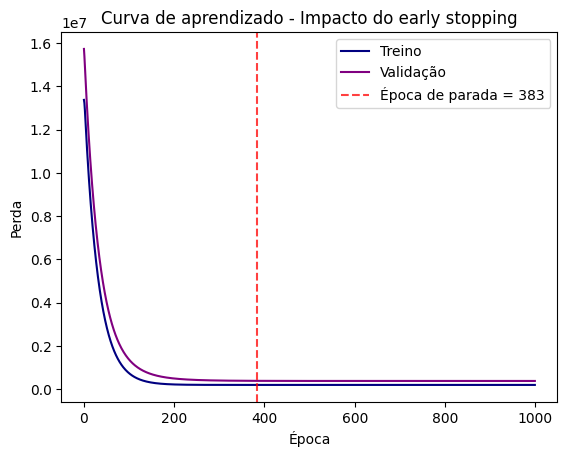

In [9]:
x = [epoca for epoca in range(NUM_EPOCAS)]

# plt.figure(dpi=200)
plt.plot(x, perda_treino, color='navy', label='Treino')
plt.plot(x, perda_validacao, color='purple', label='Valida√ß√£o')
plt.axvline(parada, linestyle='--', color='red', alpha=.75, label=f'√âpoca de parada = {parada}')

plt.title('Curva de aprendizado - Impacto do early stopping')
plt.xlabel('√âpoca')
plt.ylabel('Perda')
plt.legend();

Como se pode observar no gr√°fico acima, o crit√©rio de parada foi chamado ap√≥s a estabiliza√ß√£o da perda e poderia impedir que mais 574 √©pocas fossem executadas.

Agora, podemos rodar novamente o c√≥digo, mas dessa vez com o early stopping funcionando para partirmos para o teste do modelo. 

In [10]:
minha_mlp = MLP(
    num_dados_de_entrada, NEURONIOS_C1, NEURONIOS_C2, num_dados_de_saida
)

TAXA_DE_APRENDIZADO = 0.001

otimizador = optim.SGD(minha_mlp.parameters(), lr=TAXA_DE_APRENDIZADO)
fn_perda = nn.MSELoss()

In [11]:
NUM_EPOCAS = 1000
PATIENCE = int(0.01*NUM_EPOCAS)

escala = abs(torch.max(y_val)-torch.min(y_val))
DELTA = 0.05*escala

perda_validacao = []
contador = 0    

for epoca in range(NUM_EPOCAS):
    # TREINO -----------------------------------------------------
    minha_mlp.train()
    
        # forward pass
    y_pred = minha_mlp(X_train)

        # zero grad
    otimizador.zero_grad()

        # loss
    loss = fn_perda(y_train, y_pred)

        # backpropagation
    loss.backward()

        # atualiza par√¢metros
    otimizador.step()    
    
    
    # VALIDA√á√ÉO --------------------------------------------------
    minha_mlp.eval()
    
    with torch.no_grad():
        # forward pass
        y_pred = minha_mlp(X_val)
 
        # calcula perda
        perda_validacao += [fn_perda(y_val, y_pred).data]
        
    
    # EARLY STOPPING ---------------------------------------------
    ultimo_valor = perda_validacao[-1]
    penultimo_indice = len(perda_validacao) - 2
    penultimo_valor = perda_validacao[penultimo_indice]

    diferenca = abs(ultimo_valor - penultimo_valor)

    if diferenca <= DELTA:
        contador += 1
    else:
        contador = 0

    if contador == PATIENCE:
        parada = epoca
        print(f'√âpoca de parada: {parada}')
        break

√âpoca de parada: 383


In [12]:
minha_mlp.eval() # modo de previs√£o

with torch.no_grad():
    y_pred = minha_mlp(X_test)

y_pred

tensor([[3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624.2329],
        [3624

In [13]:
print(f'M√©dia do y_treino: {torch.mean(y_train)}')

M√©dia do y_treino: 3631.7568359375


Aqui percebemos que a nossa rede est√° prevendo sempre um valor muito pr√≥ximo da m√©dia dos dados de sa√≠da do treino, ou seja, o modelo ficou subajustado. No entanto, vale destacar que isso, muito provavelmente √© um problema na arquitetura da rede, pois, como podemos observar no gr√°fico da curva de aprendizado, o valor da perda permaneceria o mesmo ainda que o treino prosseguisse.

Por fim, calcularemos a raiz do erro quadr√°tico m√©dio das nossas previs√µes e o quanto isso representa dada a varia√ß√£o do nosso target.

In [14]:
RMSE = mean_squared_error(y_test, y_pred, squared=False)
variacao = max(y)-min(y)

print(f'RMSE: {RMSE}')
print(f'Varia√ß√£o de y = {round(variacao[0],3)}')
print(f'O RMSE representa {round((100*RMSE/variacao)[0],3)}% da varia√ß√£o de y')

RMSE: 381.1118469238281
Varia√ß√£o de y = 1925.0
O RMSE representa 19.798% da varia√ß√£o de y


---

### Conclus√£o

Embora no exemplo dado isso n√£o tenha acontecido, em muitas redes √© comum que o modelo comece a sobreajustar depois de atingir um m√≠nimo. Ainda assim, a parada antecipada √© essencial n√£o somente para evitar o overfitting como tamb√©m para poupar recurso computacional, evitando itera√ß√µes que al√©m de desnecess√°rias (caso uma estabilidade tenha sido alcan√ßada) podem vir a prejudicar o desempenho da rede.

---

### Contribui√ß√£o de cada membro

**Let√≠cia Nunes:** Pesquisa, Implementa√ß√£o e Documenta√ß√£o.

**Vitor Dreveck:** Pesquisa e Implementa√ß√£o.

---

### Refer√™ncias

1. <b>Early stopping guide. </b>Dispon√≠vel em: https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e
2. <b>Documenta√ß√£o PyTorch.</b> Dispon√≠vel em: https://pytorch.org/docs/stable/index.html
3. <b><code>ignite.EarlyStopping</code>.</b> Dispon√≠vel em: https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html
4. <b>Lidando com Doubles e achando o valor m√°ximo em um tensor.</b> Dispon√≠vel em: https://chatgpt.com/share/6807c805-7f20-8007-bd3f-60e61ab23fd7
5. <b>Implementa√ß√£o do early stopping.</b> Dispon√≠vel em: https://medium.com/biased-algorithms/a-practical-guide-to-implementing-early-stopping-in-pytorch-for-model-training-99a7cbd46e9d

---